# NLP Model

In [1]:
import pandas as pd
import numpy as np
import pickle

import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import nltk.corpus
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download('wordnet')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns

from math import ceil

from sklearn import metrics

[nltk_data] Downloading package punkt to /home/gbs/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/gbs/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/gbs/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/gbs/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /home/gbs/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Data loading

In [2]:
def pickle_load(fn):
    with open(fn, 'rb') as f:
        aux = pickle.load(f)
    return aux

In [3]:
tagged = pickle_load('nlp_pos.bin')
X_ngram = pickle_load('nlp_tf_ngram.bin')
X_tf = pickle_load('nlp_tf.bin')

data_set = pickle_load('nlp_dataset.bin')

In [4]:
data_set

,clean,corrected,hate,tokens,RT,num_words,num_sents,class
0,"[rt, mentionhere, as, a, woman, you, shouldn, ...","[it, mentionhere, as, a, woman, you, shouldn, ...",[0.0],"[mentionhere, woman, complain, cleaning, house...",1,25,1,2
1,"[rt, mentionhere, boy, dats, cold, tyga, dwn, ...","[it, mentionhere, boy, days, cold, tea, own, b...",[0.0],"[mentionhere, boy, day, cold, tea, bad, coffin...",1,17,1,1
2,"[rt, mentionhere, dawg, rt, mentionhere, you, ...","[it, mentionhere, dawn, it, mentionhere, you, ...",[0.0],"[mentionhere, dawn, mentionhere, ever, fuck, b...",2,20,1,1
3,"[rt, mentionhere, mentionhere, she, look, like...","[it, mentionhere, mentionhere, she, look, like...",[0.0],"[mentionhere, mentionhere, look, like, granny]",1,8,1,1
4,"[rt, mentionhere, the, shit, you, hear, about,...","[it, mentionhere, the, shit, you, hear, about,...",[0.0],"[mentionhere, shit, hear, might, true, might, ...",1,25,1,1
...,...,...,...,...,...,...,...,...
24778,"[you, s, a, muthafin, lie, numberhere, mention...","[you, s, a, muthafin, lie, numberhere, mention...",[0.0],"[muthafin, lie, numberhere, mentionhere, menti...",0,22,1,1
24779,"[you, ve, gone, and, broke, the, wrong, heart,...","[you, ve, gone, and, broke, the, wrong, heart,...",[0.0],"[gone, broke, wrong, heart, baby, drove, redne...",0,14,1,2
24780,"[young, buck, wanna, eat, that, nigguh, like, ...","[young, buck, anna, eat, that, nigh, like, i, ...",[0.0],"[young, buck, anna, eat, nigh, like, amant, mu...",0,13,1,1
24781,"[youu, got, wild, bitches, tellin, you, lies]","[you, got, wild, birches, tell, you, lies]",[0.0],"[got, wild, birch, tell, lie]",0,7,1,1


# 2. Sentiment analisis

In [5]:
def get_joined(r='tokens'):
    return data_set.apply(lambda row: ' '.join(row[r]), axis=1)

In [6]:
X = pd.DataFrame()
sentiment_analyzer = SentimentIntensityAnalyzer() 
sentiment = get_joined().apply(lambda row: sentiment_analyzer.polarity_scores(row))
sentiment = pd.DataFrame.from_records(sentiment)
if not any(c == 'neg' for c in X.columns):
    X = pd.concat([X, sentiment], axis=1)
else:
    X.update(sentiment)

In [7]:
X.isna().sum()

neg         0
neu         0
pos         0
compound    0
dtype: int64

In [8]:
X

,neg,neu,pos,compound
0,0.217,0.783,0.000,-0.3612
1,0.280,0.720,0.000,-0.5423
2,0.765,0.235,0.000,-0.9460
3,0.000,0.615,0.385,0.3612
4,0.430,0.407,0.163,-0.6808
...,...,...,...,...
24778,0.000,1.000,0.000,0.0000
24779,0.624,0.376,0.000,-0.8074
24780,0.000,0.762,0.238,0.3612
24781,0.000,1.000,0.000,0.0000


## 2.1. Feature selection

In [9]:
X_tf_df = pd.DataFrame.sparse.from_spmatrix(X_tf)

In [10]:
X_tf_df.shape

(24783, 11920)

In [11]:
hate = data_set['hate'].apply(lambda r: max(r))
hate.sum()

766.3710000000002

In [12]:
X = pd.concat((X, hate, X_tf_df), axis=1)

In [13]:
X = data_set[['RT','num_words','num_sents']].join(X)

In [14]:
X.isna().sum().sum()

0.0

In [15]:
X

,RT,num_words,num_sents,neg,neu,pos,compound,hate,0,1,...,11910,11911,11912,11913,11914,11915,11916,11917,11918,11919
0,1,25,1,0.217,0.783,0.000,-0.3612,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,17,1,0.280,0.720,0.000,-0.5423,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,20,1,0.765,0.235,0.000,-0.9460,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,8,1,0.000,0.615,0.385,0.3612,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,25,1,0.430,0.407,0.163,-0.6808,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24778,0,22,1,0.000,1.000,0.000,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24779,0,14,1,0.624,0.376,0.000,-0.8074,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24780,0,13,1,0.000,0.762,0.238,0.3612,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24781,0,7,1,0.000,1.000,0.000,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
size = len(X.columns)
to_cut = ceil(0.7*len(X.columns))
to_save = size - to_cut
print('100% of features: {}\n 70% of features: {}'.format(size, to_cut))

100% of features: 11928
 70% of features: 8350


In [17]:
y = data_set['class']

In [18]:
from sklearn.feature_selection import SelectKBest, chi2, f_regression

selector = SelectKBest(f_regression, k=to_save)
selector.fit(X, y)
X_new = selector.transform(X)
columns = list(X.columns[selector.get_support(indices=True)])

/home/gbs/.conda/envs/data/lib/python3.8/site-packages/sklearn/utils/validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/gbs/.conda/envs/data/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/gbs/.conda/envs/data/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/gbs/.conda/envs/data/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/gbs/.conda/envs/data/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/gbs/.conda/envs/data/lib/py

In [19]:
len(columns)

3578

In [20]:
columns[:9]

['RT', 'num_words', 'neg', 'neu', 'pos', 'compound', 'hate', 3, 6]

In [21]:
X_new.shape

(24783, 3578)

# 3. Classification algorithm

In [22]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_new, y, random_state=2, test_size=0.3)

## 3.1. Random forest

### Model training

In [23]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=10)
model.fit(Xtrain, ytrain)

RandomForestClassifier(random_state=10)

In [24]:
ypred_forest = model.predict(Xtest)

### Test results

In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

Text(91.68, 0.5, 'predicted label')

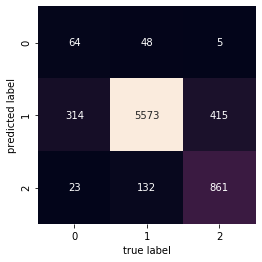

In [26]:
mat_forest = confusion_matrix(ytest, ypred_forest)
sns.heatmap(mat_forest.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [27]:
report = metrics.classification_report(ypred_forest, ytest)
print(report)

              precision    recall  f1-score   support

           0       0.16      0.55      0.25       117
           1       0.97      0.88      0.92      6302
           2       0.67      0.85      0.75      1016

    accuracy                           0.87      7435
   macro avg       0.60      0.76      0.64      7435
weighted avg       0.92      0.87      0.89      7435



In [28]:
forest_score = metrics.accuracy_score(ytest, ypred_forest)
forest_score

0.873974445191661

## 3.2. Support vector classifier

In [50]:
from sklearn.svm import LinearSVC
model_svc = LinearSVC(tol=1e-4, C=1e5, max_iter=1e4, random_state=13)
model_svc.fit(Xtrain, ytrain)
ypred_svc = model.predict(Xtest)

/home/gbs/.conda/envs/data/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


### Test results

              precision    recall  f1-score   support

           0       0.55      0.16      0.25       401
           1       0.88      0.97      0.92      5753
           2       0.85      0.67      0.75      1281

    accuracy                           0.87      7435
   macro avg       0.76      0.60      0.64      7435
weighted avg       0.86      0.87      0.86      7435



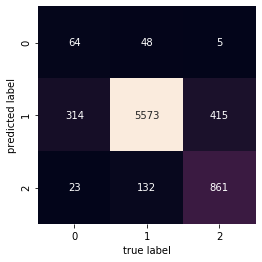

In [51]:
mat_svc = confusion_matrix(ytest, ypred_svc)
sns.heatmap(mat_svc.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
print(metrics.classification_report(ytest, ypred_svc))

In [52]:
svc_score = metrics.accuracy_score(ytest, ypred_svc)
svc_score

0.873974445191661

In [53]:
(ypred_forest == ypred_svc).sum(), len(ytest)

(7435, 7435)